# The Multi-Layer Perceptron
Any neural network is simply a series of perceptrons feeding into one another. The perceptrons are arranged in layers with the outputs of a previous layer being the inputs into the next layer.

With this in mind it seems that we did much of the heavy lifting in our [first notebook](./01. The Perceptron.ipynb) concerning the percepton - the single neuron emulating unit that is the building block of a neural network.

In this workbook we will consider the simplest case of a fully-connected network. That is a network where each node (percepton) in a given layer is connected to every node in the subsequent layer. This means that the output of a perceptron in the first layer will therefore be an input into each perceptron in the next layer.

![Neural Network Diagram](./img/neural-network.png "A Fully Connected Neural Network")

## Expressiveness of Neural Networks

## Training a Neural Network vs Training a Perceptron
Similarly to the case of the vanilla perceptron we considered before, the values passed as inputs to each layer (and therefore each perceptron in that layer) will have weights associated with them. These weights will be the variables which we will vary as part of the training process with the ultimate goal of loss minimisation.

In contrast to a single perceptron, a multi-layer perceptron must be trained in a more complex way since the weights in the first layer only have an indirect impact on the output albeit through many channels in a fully connected network. This indirect influence is difficult to trace through should the step activation function be kept. The discontinuous function is not differentiable and hence we are unable to perform what's known as backpropagation to calculate the impact of early layer weights on the ultimate output. Backpropagation is the algorithmic way of training a neural network. Errors in the output are traced back through the layers of the network and the weights are updated in turn in order to reduce the error. We will consider this process in detail later. 

In order to undertake backpropagation the error, or more specifically the model prediction, needs to be differentiable with respect to the weights. In order to achieve this, a smooth (differentiable) activation function is used in place of the perceptron step function.

These functions are known as activation functions because they play the role of the activation threshold in the perceptron or the neuron being emulated. Popular choices are the sigmoid function, tanh and the Rectified Linear Unit function (ReLU).

We will discuss the mathematics of backpropagation in detail [later](#backpropagation).


## Activation Functions
Activation functions determine how a perceptron produces its output. Unlike neurons, perceptrons are not limited to binary output and hence may produce any real number as their output. The choice of activation function can therefore shape this output by shaping the relationship between inputs and the output beyond the linear way in which weights enter the equation. This relationship change can be made for computational ease, to match the relationship we are trying to estimate or to aid in training the model.

In the case of the neurons in our brains that the perceptrons aim to emulate, activation functions play the role of the activation threshold. In the brain the threshold is placed on a concentration gradient across a membrane which much reach a certain strength before an activation potential will be passed along the neuron. In our case, working in the mathematics of real numbers we need not limit ourselves to binary output. We may consider any output on the real domain. This can be considered the number of action potentials per second should one wish to maintain the biological parallels.

### The Sigmoid Function
A binary classifier may aim to place a probability on the given input belonging to a given class. This will mean that the outputs must, by way of being probabilities, fall in the unit interval ($o \in [0,1]$). The sigmoid function will always produce outputs that are between 0 and 1 and can therefore be considered valid probabilities. The functional form of the sigmoid function is given below.

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

<small><center><span style="color:gray">*The Sigmoid Function*</span></center></small>


Note that this function is strictly increasing in $x$ and varies from $0$ when $x$ is $-\infty$ and 1 when $x$ is $\infty$. It is smooth, defined for all real numbers and differentiable.

Infact the differential takes a rather nice form which is one reason for the function's popularity. This will help us when training the model later on.


$$\sigma(x)=\frac{1}{1+e^{-x}}$$
<center><span style="color:gray">*The Sigmoid Function*</span></center>

Let's plot this function so that we can see what we're dealing with.

First we'll import our mathematical toolkit `numpy` and the plotting tools `matplotlib` and `seaborn`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Let's define our sigmoid function.

Note that we decorate it with `numpy`'s `vectorize` function so that the function can be called on lists and arrays without further modification.

In [2]:
@np.vectorize
def sigmoid(x):
    return 1/(1+np.exp(-x))

Finally let us generate some points and create a plot.

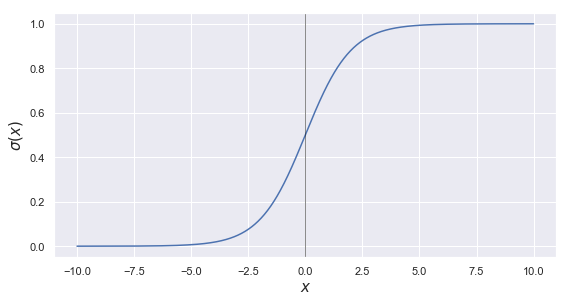

In [3]:
x = np.linspace(-10, 10, 1000)
y = sigmoid(x)
plt.plot(x,y, figure=plt.figure(figsize=(9,4.5)))
plt.axvline(0, color='k', lw=0.5)
plt.xlabel('$x$', size=15)
plt.ylabel('$\sigma(x)$', size=15);

Let us find the differential by applying the quotient rule. 

$$\frac{d\frac{u}{v}}{dx}=\frac{v\frac{du}{dx} - u\frac{dv}{dx}}{v^2}$$

<small><center><span style="color:gray">*The Quotient Rule*</span></center></small>

This leads us to the following derivative of the sigmoid function.

$$
\begin{align}
\sigma'(x) &=\frac{e^{-x}}{(1+e^{-x})^2}\\&=\frac{1}{1+e^{-x}}\cdot \frac{e^{-x}}{1+e^{-x}}\\&=\frac{1}{1+e^{-x}}\cdot\frac{(1+e^{-x})-1}{1+e^{-x}}\\&=\frac{1}{1+e^{-x}}\cdot\left(1-\frac{1}{1+e^{-x}}\right)\\&=\sigma(x)(1-\sigma(x))
\end{align}
$$

## Setting A Problem To Solve

To consider how neural networks work we need a set of data to learn from. In this case we will consider a a more complex classification problem wherein the outcome will be determined by some non-linear function of the inputs. This non-linear function is what we aim to learn with our network. First we must consider the relationship we wish to build. Let us consider a function of 5 variables.

In [4]:
a = 100 * np.random.random(10000)
b = 50  * np.random.random(10000)
c = 75  * np.random.random(10000)
d = 10  * np.random.random(10000)

Now let us define a function of these five variables that generates a surface separating positive and negative examples.

In [5]:
@np.vectorize
def hyperplane(a,b,c,d,e):
    value = 1
    if a > 75:
        value *= np.sqrt(a)
    if b < 10:
        value += b
    if c > 60 or d < 5:
        value += c * d
    return value

<a id="build"></a>
## Building the Neural Network
### The Forward Pass

$$ prediction = w_{0,O}+\sum_{j=1}^{n} w_{j,O}\cdot \sigma\left(w_{0,j}+\sum_{i=1}^{n} x_i w_{i,j}\right)$$

$$\sum_{j=1}^n w_{j,O} x_{i} \cdot \sigma\left(w_{0,j}+\sum_{i=1}^n x_i w_{i,j}\right)\left(1 - \sigma\left(w_{0,j}+\sum_{i=1}^n x_i w_{i,j}\right)\right)$$

In [40]:
def predict(x, weights):
    x = np.insert(x, 0, 1)
    output = x
    for layer in weights[:-1]:
        output = sigmoid(np.matmul(output, layer))
        output = np.insert(output, 0, 1)
    output = np.matmul(output, weights[-1])
    return output

In [34]:
def get_intermediate_outputs(x, weights, layer):
    x = np.insert(x, 0, 1)
    output = x
    full_network = False
    if layer == len(weights):
        layer -= 1
        full_network = True
    for i in range(layer):
        output = sigmoid(np.matmul(output, weights[i]))
        output = np.insert(output, 0, 1)
    if full_network:
        output = np.matmul(output, weights[-1])
    return output

In [37]:
w = [
        np.array([[1,1,1,1,1],
        [2,2,2,2,2],
        [3,3,3,3,3],
        [4,4,4,4,4],
        [5,5,5,5,5]]),
        
        np.array([[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6]])
    ]

In [28]:
i = np.array([0.003, 0.19, 0.1, 0.39])

In [41]:
predict(i, w)

array([2.06131809])

<a id="backpropagation"></a>
## Backpropagation

In [76]:
def calculate_gradients(inputs, weights):
    no_layers = len(weights)
    predictions = predict(inputs, weights)
    final_layer_derivatives = get_intermediate_outputs(inputs, weights, no_layers - 1)
    first_layer_outputs = get_intermediate_outputs(inputs, weights, 1)
    previous_layer_derivatives = np.array([])
    for i in range(len(inputs) + 1):
        for j in range(weights[-2].shape[1]):
            if i == 0:
                gradient = 1 * weights[-1][j]
            else:
                gradient = inputs[i-1] * weights[-1][j] * first_layer_outputs[j] * (1 - first_layer_outputs[j])
            previous_layer_derivatives = np.append(previous_layer_derivatives, gradient)
    previous_layer_derivatives = np.reshape(previous_layer_derivatives, weights[-2].shape)
    return [previous_layer_derivatives, final_layer_derivatives]

In [77]:
calculate_gradients(i, w)

[array([[1.00000000e-01, 2.00000000e-01, 3.00000000e-01, 4.00000000e-01,
         5.00000000e-01],
        [0.00000000e+00, 1.13801292e-05, 1.70701938e-05, 2.27602583e-05,
         2.84503229e-05],
        [0.00000000e+00, 7.20741514e-04, 1.08111227e-03, 1.44148303e-03,
         1.80185379e-03],
        [0.00000000e+00, 3.79337639e-04, 5.69006459e-04, 7.58675278e-04,
         9.48344098e-04],
        [0.00000000e+00, 1.47941679e-03, 2.21912519e-03, 2.95883358e-03,
         3.69854198e-03]]),
 array([1.        , 0.98065905, 0.98065905, 0.98065905, 0.98065905,
        0.98065905])]

In [78]:
def backprop(inputs, weights, true_values, epochs, eta):
    w = np.copy(weights)
    for _ in epochs:
        for i, t in zip(inputs, true_values):
            predictions = predict(i, w)
            grads = calculate_gradients(i, w)
            update = []
            for layer_grad in grads:
                update.append(-eta * (t - predictions) * layer_grad)
            for l in range(len(w)):
                w[l] += update[l]
    return w